```{contents}
``` 

# XGBoost Regressor

The **XGBoost Regressor** is a machine learning algorithm used for **predicting continuous values** (regression tasks). It is based on **gradient boosting** but optimized with additional tricks for speed, scalability, and regularization.

It combines:

* **Ensemble learning** → multiple weak learners (decision trees)
* **Gradient boosting** → trees are added sequentially, correcting previous errors
* **Second-order optimization** → uses both gradient & Hessian for better approximation
* **Regularization** → prevents overfitting

---

## Mathematical Formulation

We want to predict a continuous target $y$ from input $x$.

### 1. Prediction function:

$$
\hat{y}_i = \sum_{t=1}^T f_t(x_i), \quad f_t \in \mathcal{F}
$$

* $f_t$ = regression tree at step $t$
* $\mathcal{F}$ = space of possible regression trees

---

### 2. Objective function

$$
\text{Obj} = \sum_{i=1}^n L(y_i, \hat{y}_i) + \sum_{t=1}^T \Omega(f_t)
$$

* **Loss function** $L(y_i, \hat{y}_i)$: measures prediction error

  * Common: Mean Squared Error (MSE), MAE, Huber loss.
* **Regularization term** $\Omega(f_t)$: penalizes complexity of trees

  $$
  \Omega(f_t) = \gamma T + \frac{1}{2}\lambda \sum_j w_j^2
  $$

  * $T$ = number of leaves in the tree
  * $w_j$ = leaf weight
  * $\gamma, \lambda$ = regularization parameters

---

### 3. Tree building using Taylor expansion

To minimize the objective, XGBoost expands the loss function up to **second-order**:

$$
\text{Obj}^{(t)} \approx \sum_{i=1}^n \left[ g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2 \right] + \Omega(f_t)
$$

where:

* $g_i = \frac{\partial L(y_i, \hat{y}_i)}{\partial \hat{y}_i}$ (gradient)
* $h_i = \frac{\partial^2 L(y_i, \hat{y}_i)}{\partial \hat{y}_i^2}$ (Hessian)

---

### 4. Leaf weight solution

For a leaf $j$, the optimal weight is:

$$
w_j^* = -\frac{\sum_{i \in I_j} g_i}{\sum_{i \in I_j} h_i + \lambda}
$$

* $I_j$ = set of samples in leaf $j$.

---

### 5. Split Gain

When deciding to split, compute **Gain**:

$$
\text{Gain} = \frac{1}{2}\left(\frac{G_L^2}{H_L+\lambda} + \frac{G_R^2}{H_R+\lambda} - \frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right) - \gamma
$$

* Split if **Gain > 0** (or above threshold).

---

## Workflow of XGBRegressor

1. **Input data** → convert to DMatrix (efficient internal format).
2. **Initialize prediction** with mean of $y$.
3. For each boosting round:

   * Compute gradients & Hessians of loss function.
   * Build a regression tree using Gain formula.
   * Assign leaf weights using closed-form solution.
   * Update predictions:

     $$
     \hat{y}^{(t)} = \hat{y}^{(t-1)} + \eta f_t(x)
     $$

     where $\eta$ = learning rate.
4. Apply **regularization** (L1 & L2 penalties).
5. Repeat until max trees or early stopping.

---

## Key Hyperparameters in XGBRegressor

* **Learning rate (eta)** → step size (default 0.3).
* **n\_estimators** → number of boosting rounds.
* **max\_depth** → depth of each tree.
* **subsample** → % of training data used per tree.
* **colsample\_bytree** → % of features used per tree.
* **reg\_alpha (L1)** & **reg\_lambda (L2)** → regularization.
* **gamma** → minimum loss reduction required to split.
* **min\_child\_weight** → minimum sum of Hessians in a leaf.

---

## Use Cases

* Predicting **house prices** 🏠
* Forecasting **stock prices** 📈
* Modeling **customer spending** 💳
* Any **tabular regression task** with non-linear interactions

---

**Intuition**:
XGBRegressor keeps adding **small trees** that fix residual errors from the previous trees, using **gradients + curvature info**. Regularization ensures the model doesn’t overfit.

In [2]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/00/5a/f43bad68b31269a72bdd66102732ea4473e98f421ee9f71379e35dcb56f5/xgboost-3.0.5-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.4/56.8 MB 9.1 MB/s eta 0:00:07
    --------------------------------------- 0.9/56.8 MB 9.6 MB/s eta 0:00:06
   - -------------------------------------- 1.5/56.8 MB 10.3 MB/s eta 0:00:06
   - -------------------------------------- 2.1/56.8 MB 11.3 MB/s eta 0:00:05
   - -------------------------------------- 2.8/56.8 MB 11.9 MB/s eta 0:00:05
   -- ------------------------------------- 3.4/56.8 MB 12.9 MB/s eta 0:00:05
   -- ------------------------------------- 4.1/56.8 MB 13.2 MB/s eta 0:00:04
   --- ------------------------------------ 4.7/56.8 MB 13.0 MB/s eta 0:00:05
   --- ------------------------------------ 5.4/56.8 MB 13.4 MB/s eta 0:00:04
   ---- -----------------


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Mean Squared Error: 396.4587759694509


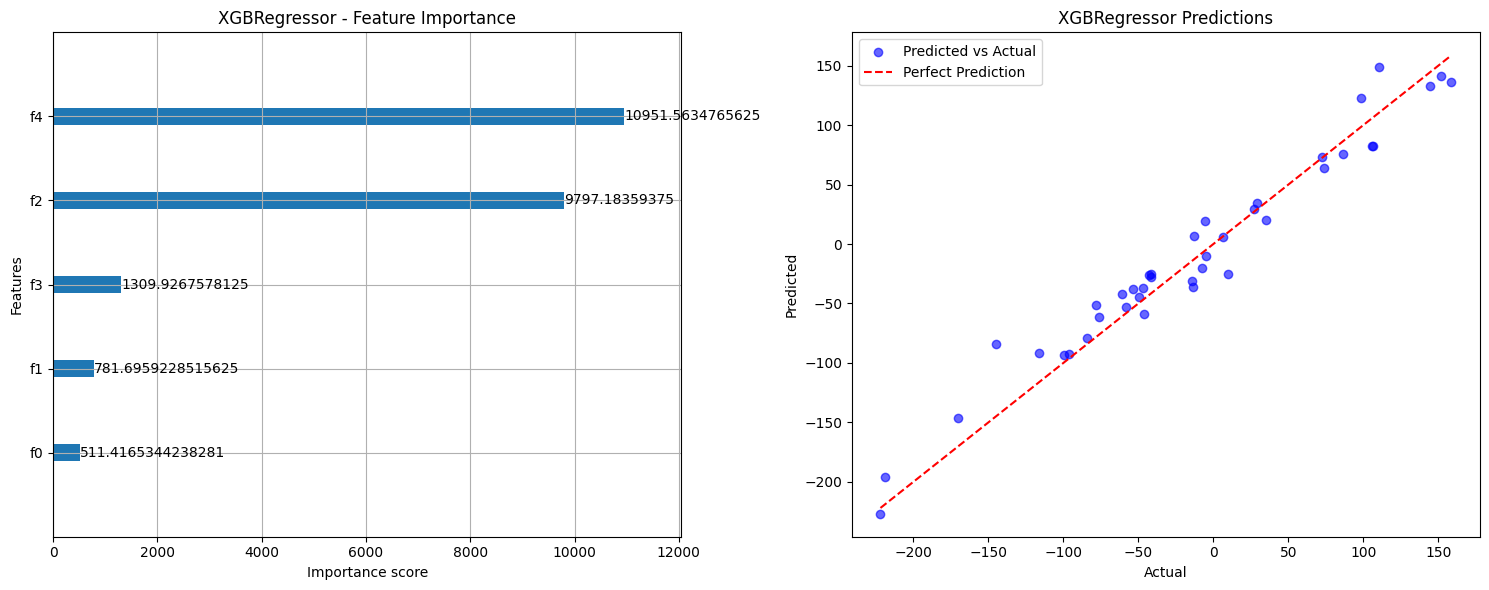

In [9]:
# ------------------------------
# Fixed XGBRegressor Demonstration
# ------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, plot_importance

# 1. Generate synthetic regression dataset
X, y = make_regression(n_samples=200, n_features=5, noise=15, random_state=42)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train XGBRegressor
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=42
)

model.fit(X_train, y_train)

# 3. Evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# 4 & 5. Plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Feature importance
plot_importance(model, importance_type="gain", ax=axes[0])
axes[0].set_title("XGBRegressor - Feature Importance")

# Predictions vs actual
axes[1].scatter(y_test, y_pred, color="blue", alpha=0.6, label="Predicted vs Actual")
axes[1].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             color="red", linestyle="--", label="Perfect Prediction")
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predicted")
axes[1].set_title("XGBRegressor Predictions")
axes[1].legend()

plt.tight_layout()
plt.show()
